In [1]:
import numpy as np 
import pandas as pd
import string
from tqdm import tqdm
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import re
_wnl = nltk.WordNetLemmatizer()
from sklearn import feature_extraction
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\visha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def normalize_word(w):
    return _wnl.lemmatize(w).lower()

def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]

def clean(text):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation),''))
    return " ".join(re.findall(r'\w+', text, flags=re.UNICODE)).lower()

def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]
    
def join_tok(text):
    return " ".join(text).lower()


In [3]:
def pre_process(texts):
    lst=[]
    for text in tqdm(texts):
        clean_text= clean(text)
        tok_text= get_tokenized_lemmas(clean_text)
        remov_stp= remove_stopwords(tok_text)
        lst.append(join_tok(remov_stp))
    return lst

In [4]:
data= pd.read_csv('../../Data/clickBait_Data.csv')

In [5]:
data.head()

,index,id,titles,clickbait
0,42179,42180,Arvind Panagariya raises first red flag on tax...,0
1,30990,30991,"As an Iranian Briton, Theresa May's support fo...",1
2,21403,21404,"In Trump's ongoing feud about Russia, he says ...",0
3,14415,14416,You Me at Six: Night People review overwrough...,0
4,23421,23422,"Dylann Roof, Addressing Court, Offers No Apolo...",0


In [6]:
titles=  pre_process(data['titles'])


100%|██████████| 59172/59172 [02:13<00:00, 441.71it/s] 


In [7]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=300, stop_words='english',ngram_range=(1,4))

In [8]:
tfidf_vect.fit(titles)

TfidfVectorizer(max_features=300, ngram_range=(1, 4), stop_words='english')

In [9]:
titleFeatures= tfidf_vect.transform(titles).toarray()

In [10]:
labels= data['clickbait'].tolist()

In [11]:
train_feat, test_feat, train_labels, test_labels= train_test_split(titleFeatures,labels,test_size= 0.2,shuffle=True)

In [12]:

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

In [13]:
mnb.fit(train_feat,train_labels)

MultinomialNB()

In [14]:
prediction= mnb.predict(test_feat)

In [15]:
accuracy_score(test_labels,prediction)

0.7077313054499367

In [16]:
featureLen= train_feat.shape[1]

In [17]:
model= Sequential()
model.add(Dense(300,activation='relu', input_shape=(featureLen,)))
model.add(Dense(160,activation='relu'))
model.add(Dense(80,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


c:\Users\visha\anaconda3\envs\pyenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
filepath=r"CB1-tfidf_nn_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [19]:
model.compile(loss = 'mse', optimizer='adam',metrics = ['accuracy'])


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │        48,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │        12,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │         4,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,431 (611.06 KB)

 Trainable params: 156,431 (611.06 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
train_feat = np.array(train_feat)
train_labels = np.array(train_labels)

model.fit(train_feat, train_labels, epochs=1, batch_size=1, verbose=1, validation_split=0.05, shuffle=True, callbacks=callbacks_list)

44970/44970 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7454 - loss: 0.1705
Epoch 1: val_accuracy improved from 0.71356 to 0.71905, saving model to CB1-tfidf_nn_weights-improvement-01-0.72.hdf5.keras
44970/44970 ━━━━━━━━━━━━━━━━━━━━ 724s 16ms/step - accuracy: 0.7454 - loss: 0.1705 - val_accuracy: 0.7191 - val_loss: 0.1833


In [35]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
tok= Tokenizer()
model_json = model.to_json()
with open("../../output/nn/nn_clickbait_new.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("../../output/nn/nn_clickBait_new.weights.h5")

with open('../../output/nn/tokenizer_tfidf.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
prediction= model.predict(test_feat)
YClass= np.zeros((len(prediction)))

370/370 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


In [29]:
test_feat = np.array(test_feat)
test_labels = np.array(test_labels)

acc,scor= model.evaluate(test_feat,test_labels)

370/370 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7305 - loss: 0.1787


In [30]:
acc, scor

(0.1777219921350479, 0.730460524559021)

In [31]:
for i in range(len(prediction)):
    if prediction[i][0]>=0.5:
        YClass[i]=1
    else:
        YClass[i]=0

In [32]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments   
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
#matrix1 = confusion_matrix(test_labels, prediction)



In [33]:
matrix1 = confusion_matrix(test_labels, YClass)


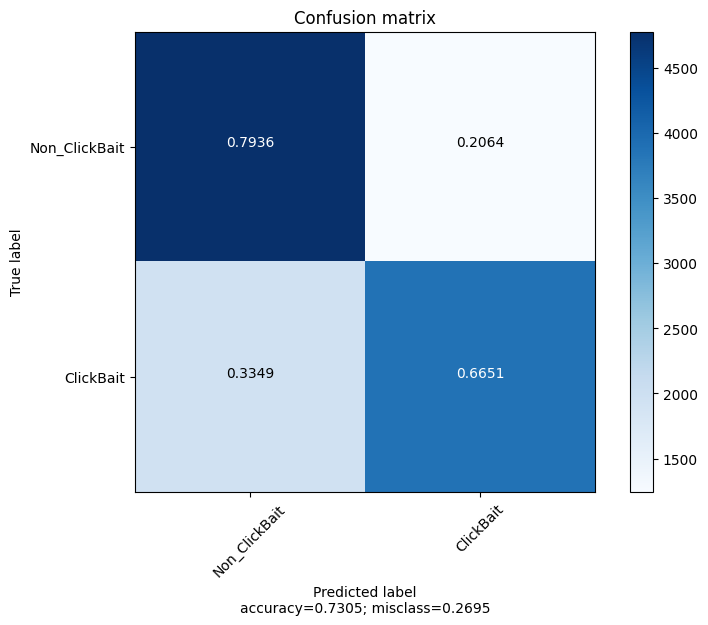

In [34]:
plot_confusion_matrix(cm=matrix1,target_names=['Non_ClickBait', 'ClickBait'])